# Importing Dependencies

In [1]:
import pandas as pd
import numpy as np
import json 

# Processing Data

In [2]:
temp_lst = list()

with open('../data/data.json', 'rb') as f:
    for line in f:
        temp1 = json.loads(line)

        for gene_id, reads in temp1.items():
            
            for read_pos, trans_vals in reads.items():

                for trans_id, vals in trans_vals.items():
                    
                    for val in vals:
                        row1 = (gene_id, read_pos, trans_id, val)
                        temp_lst.append(row1)

In [3]:
df = pd.DataFrame(temp_lst, columns=['transcript_id', 'transcript_position', 'nucleotides', 'val'])
temp = pd.DataFrame(df.val.tolist(), index= df.index)

df = pd.concat([df, temp], axis=1)
df.drop(columns=['val'], inplace=True)

In [4]:
df['n0'] = df['nucleotides'].str[:-2]
df['n1'] = df['nucleotides'].str[1:-1]
df['n2'] = df['nucleotides'].str[2:]

In [5]:
df_n0 = df[['transcript_id', 'transcript_position', 'nucleotides', 'n0', 0, 1, 2]].copy()
df_n1 = df[['transcript_id', 'transcript_position', 'nucleotides', 'n1', 3, 4, 5]].copy()
df_n2 = df[['transcript_id', 'transcript_position', 'nucleotides', 'n2', 6, 7, 8]].copy()

df_n0.rename(columns={'nucleotides': 'parent', 'n0': 'nucleotides'}, inplace = True)
df_n1.rename(columns={'nucleotides': 'parent', 'n1': 'nucleotides', 3:0, 4:1, 5:2 }, inplace = True)
df_n2.rename(columns={'nucleotides': 'parent', 'n2': 'nucleotides', 6:0, 7:1, 8:2 }, inplace = True)

df_n0['flank_pos'] = -1
df_n1['flank_pos'] = 0
df_n2['flank_pos'] = 1


df = pd.concat([df_n0, df_n1, df_n2], axis=0)
df.rename(columns={0:'dwelling_time', 1:'std_dev', 2:'mean'}, inplace=True)
df

,transcript_id,transcript_position,parent,nucleotides,dwelling_time,std_dev,mean,flank_pos
0,ENST00000000233,244,AAGACCA,AAGAC,0.00299,2.06,125.0,-1
1,ENST00000000233,244,AAGACCA,AAGAC,0.00631,2.53,125.0,-1
2,ENST00000000233,244,AAGACCA,AAGAC,0.00465,3.92,109.0,-1
3,ENST00000000233,244,AAGACCA,AAGAC,0.00398,2.06,125.0,-1
4,ENST00000000233,244,AAGACCA,AAGAC,0.00664,2.92,120.0,-1
...,...,...,...,...,...,...,...,...
11027101,ENST00000641834,1693,TTGACAT,GACAT,0.01000,2.01,76.4,1
11027102,ENST00000641834,1693,TTGACAT,GACAT,0.01760,2.61,74.6,1
11027103,ENST00000641834,1693,TTGACAT,GACAT,0.00316,2.28,85.3,1
11027104,ENST00000641834,1693,TTGACAT,GACAT,0.00664,4.44,76.8,1


# Feature Engineering

## Helper Functions

In [6]:
def get_pairing_composition(pairing, nucleotides_lst, results_lst):
    for nucleotide in nucleotides_lst:
        if pairing in nucleotide:
            pairing_count = nucleotide.count(pairing)
            pairing_composition = (pairing_count)/(len(nucleotide)-pairing_count)
            results_lst.append(pairing_composition)
        else:
            results_lst.append(0)
    return results_lst

def get_composition(letter, nucleotides_lst, results_lst):
    for nucleotide in nucleotides_lst:
        if letter in nucleotide:
            letter_count = nucleotide.count(letter)
            letter_composition = letter_count/len(nucleotide)
            results_lst.append(letter_composition)
        else:
            results_lst.append(0)
    return results_lst

## Pairing Compositions

In [7]:
AT_PAIRING_COMPOSITION = []
GC_PAIRING_COMPOSITION = []
G_COMPOSITION = []
C_COMPOSITION = []

In [ ]:
get_pairing_composition('AT', list(df['nucleotides']), AT_PAIRING_COMPOSITION)  
get_pairing_composition('GC', list(df['nucleotides']), GC_PAIRING_COMPOSITION) 
get_composition('G', list(df['nucleotides']), G_COMPOSITION)
get_composition('C', list(df['nucleotides']), C_COMPOSITION)

In [9]:
df['AT_composition'] = AT_PAIRING_COMPOSITION
df['GC_composition'] = GC_PAIRING_COMPOSITION
df['G_composition'] = G_COMPOSITION
df['C_composition'] = C_COMPOSITION

In [10]:
df.head()

,transcript_id,transcript_position,parent,nucleotides,dwelling_time,std_dev,mean,flank_pos,AT_composition,GC_composition,G_composition,C_composition
0,ENST00000000233,244,AAGACCA,AAGAC,0.00299,2.06,125.0,-1,0.0,0,0.2,0.2
1,ENST00000000233,244,AAGACCA,AAGAC,0.00631,2.53,125.0,-1,0.0,0,0.2,0.2
2,ENST00000000233,244,AAGACCA,AAGAC,0.00465,3.92,109.0,-1,0.0,0,0.2,0.2
3,ENST00000000233,244,AAGACCA,AAGAC,0.00398,2.06,125.0,-1,0.0,0,0.2,0.2
4,ENST00000000233,244,AAGACCA,AAGAC,0.00664,2.92,120.0,-1,0.0,0,0.2,0.2


In [11]:
# groupby and agg using mean 
temp1 = df.groupby(by = ['transcript_id', 'transcript_position', 'parent']).mean()
temp1.reset_index(inplace = True)
temp1 = temp1.astype({'transcript_id':'str','transcript_position': 'str'})

/tmp/ipykernel_2018/2916288419.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp1 = df.groupby(by = ['transcript_id', 'transcript_position', 'parent']).mean()


In [12]:
df2 = pd.read_csv('../data/data.info')
df2 = df2.astype({'transcript_position': 'str', 'transcript_id':'str'})
df2.head()

,gene_id,transcript_id,transcript_position,label
0,ENSG00000004059,ENST00000000233,244,0
1,ENSG00000004059,ENST00000000233,261,0
2,ENSG00000004059,ENST00000000233,316,0
3,ENSG00000004059,ENST00000000233,332,0
4,ENSG00000004059,ENST00000000233,368,0


In [15]:
df_full = df2.merge(temp1, how='left', right_on = ['transcript_id', 'transcript_position'], left_on = ['transcript_id', 'transcript_position'])
df_full.head()

,gene_id,transcript_id,transcript_position,label,parent,dwelling_time,std_dev,mean,flank_pos,AT_composition,GC_composition,G_composition,C_composition
0,ENSG00000004059,ENST00000000233,244,0,AAGACCA,0.008328,5.330978,110.062162,0.0,0.000000,0.0,0.200000,0.333333
1,ENSG00000004059,ENST00000000233,261,0,CAAACTG,0.007044,3.153186,103.953876,0.0,0.000000,0.0,0.066667,0.266667
2,ENSG00000004059,ENST00000000233,316,0,GAAACAG,0.007514,2.890130,97.929009,0.0,0.000000,0.0,0.133333,0.200000
3,ENSG00000004059,ENST00000000233,332,0,AGAACAT,0.008451,3.870690,105.448500,0.0,0.083333,0.0,0.133333,0.200000
4,ENSG00000004059,ENST00000000233,368,0,AGGACAA,0.010733,5.515202,108.352525,0.0,0.000000,0.0,0.333333,0.200000


In [17]:
# input for prediction -> (transcript_id, transcript_pos) -> output probability
# use (transcript_id, transcript_pos) as indexer to look up row values for prediction
df_feature = df_full.drop(columns=['gene_id', 'transcript_id', 'transcript_position', 'label', 'parent', 'flank_pos', 'GC_composition'])
df_label = df_full[['label']]

<AxesSubplot: >

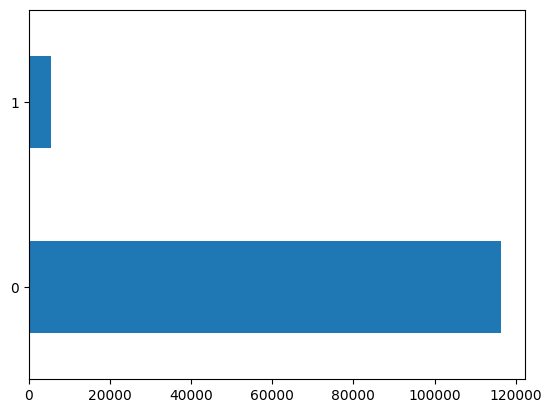

In [18]:
df_label.label.value_counts().plot(kind = 'barh')

/tmp/ipykernel_2018/1755363421.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(df_feature.corr(), fignum=f.number)


Text(0.5, 1.0, 'Correlation Matrix')

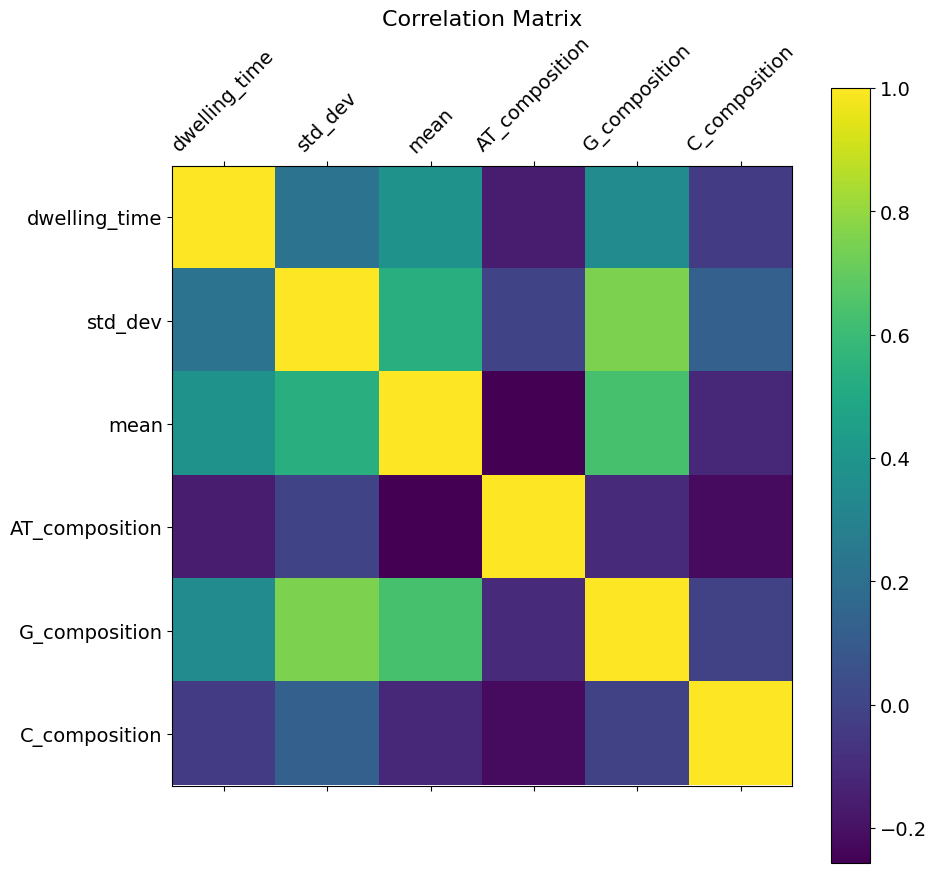

In [19]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(10, 10))

plt.matshow(df_feature.corr(), fignum=f.number)
plt.xticks(range(df_feature.select_dtypes(['number']).shape[1]), df_feature.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df_feature.select_dtypes(['number']).shape[1]), df_feature.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [20]:
from collections import Counter

# count examples in each class
count_label = Counter(df_label['label'])
# estimate scale_pos_weight value
estimate = count_label[0] / count_label[1]
print('Estimate: %.3f' % estimate)

Estimate: 21.254


In [29]:
from sklearn.model_selection import train_test_split

seed = 42 

unique_gene_ids = list(df_full['gene_id'].unique())
gtr = unique_gene_ids[:int(0.8 * len(unique_gene_ids))]
gte = unique_gene_ids[int(0.8 * len(unique_gene_ids)):]

df_tr = df_full.loc[df_full['gene_id'].isin(gtr)]
df_te = df_full.loc[df_full['gene_id'].isin(gte)]

X_train = df_tr.drop(columns=['gene_id', 'transcript_id', 'transcript_position', 'label', 'parent', 'flank_pos', 'GC_composition'])
y_train = df_tr[['label']]
X_test = df_te.drop(columns=['gene_id', 'transcript_id', 'transcript_position', 'label', 'parent', 'flank_pos', 'GC_composition'])
y_test = df_te[['label']]
# X_train, X_test, y_train, y_test  = train_test_split(df_feature, df_label, test_size=0.2, random_state=seed)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=seed) 

In [24]:
# initial model 
import xgboost as xgb
from xgboost import XGBClassifier 
from math import floor

# fit model on training data
xgb_model = XGBClassifier(objective='binary:logistic',
        scale_pos_weight = floor(estimate),
        max_delta_step = 1,
        seed = seed,
        verbosity = 3)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_pred

[15:35:48] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[15:35:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[15:35:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[15:35:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[15:35:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[15:35:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[15:35:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[15:35:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[15:35:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[15:35:49] INFO: ../src

array([0, 0, 0, ..., 1, 1, 0])

In [25]:
# create random classifier curve
y_pred_prob = xgb_model.predict_proba(X_test)
y_pred_prob = y_pred_prob[:, 1]
y_pred_prob

array([0.3836836 , 0.13088313, 0.01288808, ..., 0.8491867 , 0.52230376,
       0.03217164], dtype=float32)

Accuracy: 79.15%
f1score: 79.15%
Random Classifier: ROC AUC=0.500
Logistic: ROC AUC=0.850


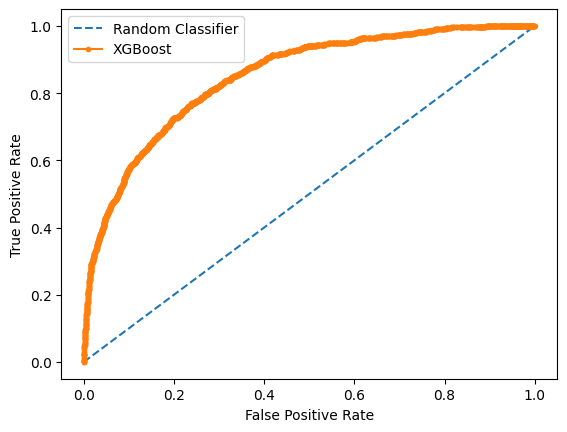

In [26]:
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
from numpy import mean
# Model will be evaluated on the ROC AUC and PR AUC of the validation dataset

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
f1score = f1_score(y_test, y_pred, average = 'micro')
print("f1score: %.2f%%" % (f1score * 100.0))


# create random classifier curve
rc_prob = [0 for _ in range(len(y_test))]

y_pred_prob = xgb_model.predict_proba(X_test)
y_pred_prob = y_pred_prob[:, 1]

rc_pred_auc = roc_auc_score(y_test, rc_prob)
y_pred_auc = roc_auc_score(y_test, y_pred_prob)

print('Random Classifier: ROC AUC=%.3f' % (rc_pred_auc))
print('Logistic: ROC AUC=%.3f' % (y_pred_auc))

# calculate roc curves
rc_fpr, rc_tpr, _ = roc_curve(y_test, rc_prob)
y_fpr, y_tpr, _ = roc_curve(y_test, y_pred_prob)

# plot the roc curve for the model
pyplot.plot(rc_fpr, rc_tpr, linestyle='--', label='Random Classifier')
pyplot.plot(y_fpr, y_tpr, marker='.', label='XGBoost')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Logistic: f1=0.195 auc=0.241


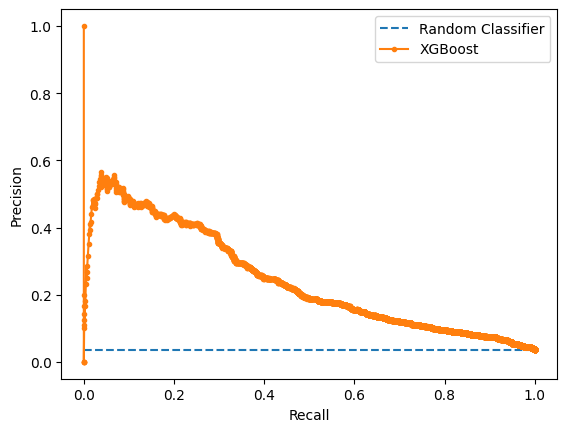

In [27]:
# PR AUC 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

y_pred = xgb_model.predict(X_test)

xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, y_pred_prob)
xgb_f1, xgb_auc = f1_score(y_test, y_pred), auc(xgb_recall, xgb_precision)

# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (xgb_f1, xgb_auc))
# plot the precision-recall curves
random_classifier = len(y_test[y_test['label']==1]) / len(y_test)
pyplot.plot([0, 1], [random_classifier, random_classifier], linestyle='--', label='Random Classifier')
pyplot.plot(xgb_recall, xgb_precision, marker='.', label='XGBoost')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Save model

In [34]:
import os
MODEL_DIR = os.path.join(os.path.expanduser('~'), 'studies/ProjectStorage/tanyeejet/models')
xgb_model.save_model(os.path.join(MODEL_DIR, 'xgb4_2.model'))

In [30]:
# save data for testing
X_test.to_csv('../data/xgb2_feature.csv', index=False)
y_test.to_csv('../data/xgb2_label.csv', index=False)